# Basic Classifiser for Specific AV

Create a basic classifier for specific vendors, meaning it trains and validates the samples based on a single vendor.

In [1]:
import pandas as pd
import numpy as np
import lib.data_loading as jcfg_data_loading
import lib.helpers as jcfg_helpers
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


test_size = 0.50

# Use the original samples to remove all but the last submission of duplicated samples
samples = pd.read_csv('data/mined_data/pe32_samples.csv')
samples = jcfg_data_loading.set_pd_datetime_index(samples)
samples.drop_duplicates(subset='md5', inplace=True, keep='last')

## Microsoft Classifier

**Ignoring temporal consistency**, train and test a classifier for microsoft only samples

In [2]:
# Load the needed CSVs
static_imports = pd.read_csv('data/mined_data/pe32_static_imports.csv', dtype=str)
static_imports = static_imports.set_index('link')

microsoft_samples = pd.read_csv('data/mined_data/microsoft_classification.csv', dtype=str)
microsoft_samples = microsoft_samples.set_index('link')

# Join the microsoft samples with the imports
dataset = microsoft_samples.join(static_imports).dropna(subset=['imports'])
dataset.drop(['info', 'variant', 'family', 'platform'], axis=1, inplace=True)
# Remove dups
dataset = dataset[dataset.index.isin(samples.link)]

dataset.type.fillna(value=0, inplace=True)


# Filter types of malware
dataset = dataset[(dataset.type == 'worm') | (dataset.type == 0)]


dataset.type = dataset.type.replace(to_replace=None, value=1, regex=r'.+').astype(int)
dataset.rename(columns={'type': 'malware'}, inplace=True)

print('Malware in dataset: {}'.format(len(dataset[dataset.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset[dataset.malware == 0])))

Malware in dataset: 10062
Goodware in dataset: 154556


In [3]:
# How imports vary on malware/goodware
microsoft_malware = dataset[dataset.malware == 1]
microsoft_goodware = dataset[dataset.malware == 0]

mcm_count = microsoft_malware.imports.apply(lambda x: len(x.split(';')))
mcg_count = microsoft_goodware.imports.apply(lambda x: len(x.split(';')))

print('Statistics on malware imports:')
display(mcm_count.describe())
print('\nStatistics on goodware imports:')
display(mcg_count.describe())

Statistics on malware imports:


count    10062.000000
mean        51.105645
std         88.978446
min          1.000000
25%          7.000000
50%         13.000000
75%         68.000000
max       1112.000000
Name: imports, dtype: float64


Statistics on goodware imports:


count    154556.000000
mean        124.116689
std         176.287262
min           1.000000
25%          19.000000
50%          83.000000
75%         154.000000
max       13325.000000
Name: imports, dtype: float64

CC:	0.9678
DR:	0.6242
FP:	0.1920
FN:	0.0242

Malware stats:


count    5.050000e+03
mean     6.104975e-01
std      3.628413e-01
min      2.198909e-15
25%      2.762046e-01
50%      6.752538e-01
75%      9.722760e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    7.725900e+04
mean     9.725752e-01
std      9.094104e-02
min      1.355972e-07
25%      9.894743e-01
50%      9.977400e-01
75%      9.999279e-01
max      1.000000e+00
dtype: float64

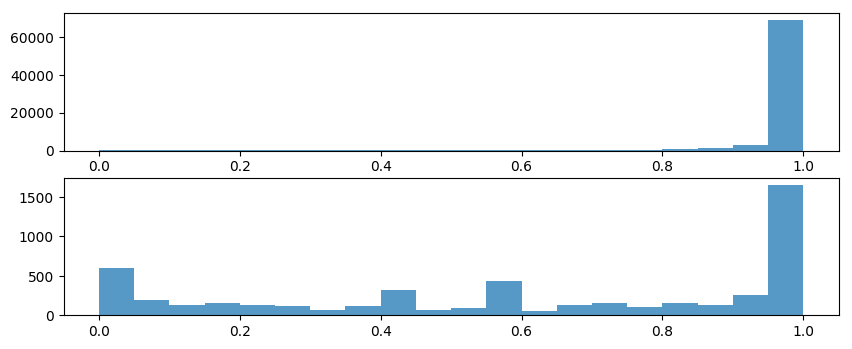

CPU times: user 43.4 s, sys: 963 ms, total: 44.4 s
Wall time: 43.7 s


In [4]:
%%time
# Raw LR, use all imports, dataset balanced as is (more goodware than malware)
# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 10062
Goodware in dataset: 10062
CC:	0.8876
DR:	0.8918
FP:	0.1143
FN:	0.1104

Malware stats:


count    5065.000000
mean        0.849589
std         0.249135
min         0.000001
25%         0.861945
50%         0.949386
75%         0.991466
max         1.000000
dtype: float64


Goodware stats:


count    4.997000e+03
mean     8.364215e-01
std      2.461619e-01
min      4.238832e-13
25%      8.504363e-01
50%      9.532463e-01
75%      9.985105e-01
max      1.000000e+00
dtype: float64

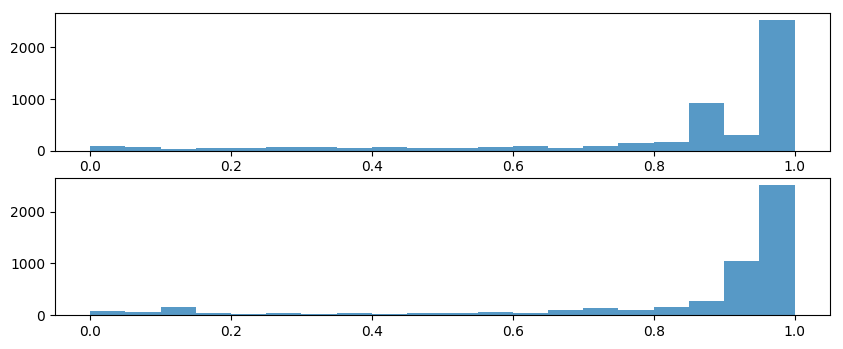

CPU times: user 2.45 s, sys: 303 ms, total: 2.75 s
Wall time: 2.38 s


In [5]:
%%time
# Use all imports, but balance the datasets
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
goodware = dataset[dataset.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset2 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset2[dataset2.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset2[dataset2.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset2, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 10062
Goodware in dataset: 5031
CC:	0.8943
DR:	0.9258
FP:	0.0814
FN:	0.1578

Malware stats:


count    5105.000000
mean        0.890684
std         0.210304
min         0.000002
25%         0.914812
50%         0.969450
75%         0.995382
max         1.000000
dtype: float64


Goodware stats:


count    2.442000e+03
mean     7.673661e-01
std      2.959465e-01
min      1.019629e-11
25%      7.268482e-01
50%      9.153821e-01
75%      9.957898e-01
max      1.000000e+00
dtype: float64

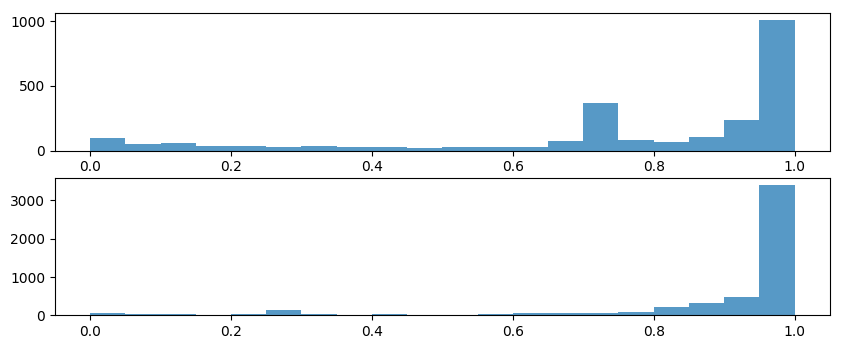

CPU times: user 1.73 s, sys: 320 ms, total: 2.05 s
Wall time: 1.68 s


In [6]:
%%time
# Use all imports, but use more malware for training (more goodware version is default)
malware_count = len(dataset[dataset.malware == 1])
goodware_count = len(dataset[dataset.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset[dataset.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset[dataset.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset3 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset3[dataset3.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset3[dataset3.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset3, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 116125
CC:	0.9647
DR:	0.6676
FP:	0.1664
FN:	0.0268

Malware stats:


count    4.759000e+03
mean     6.382442e-01
std      3.468643e-01
min      2.585901e-11
25%      3.861791e-01
50%      6.857435e-01
75%      9.687498e-01
max      1.000000e+00
dtype: float64


Goodware stats:


count    58021.000000
mean         0.969433
std          0.096376
min          0.000004
25%          0.989276
50%          0.998423
75%          0.999879
max          1.000000
dtype: float64

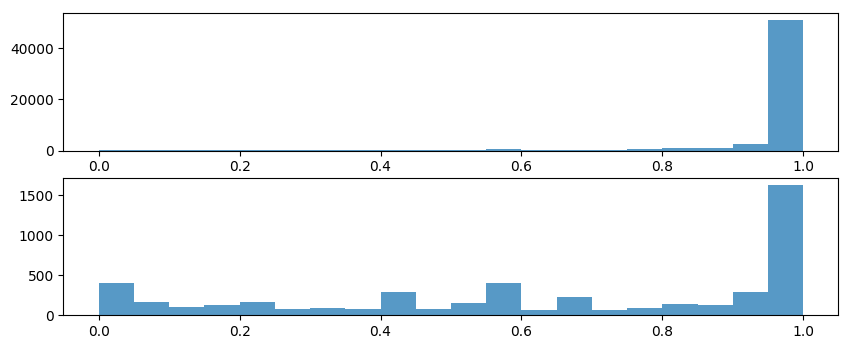

CPU times: user 16.8 s, sys: 413 ms, total: 17.2 s
Wall time: 16.7 s


In [7]:
%%time
# Use between 2 and 300 imports (+/- mean + std for goodware), without balancing
# Filter samples by the number of imports
dataset4 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]

print('Malware in dataset: {}'.format(len(dataset4[dataset4.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset4[dataset4.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset4, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 9434
CC:	0.8937
DR:	0.9133
FP:	0.1216
FN:	0.0898

Malware stats:


count    4.706000e+03
mean     8.627955e-01
std      2.315354e-01
min      2.372510e-07
25%      8.754221e-01
50%      9.472968e-01
75%      9.956253e-01
max      9.999996e-01
dtype: float64


Goodware stats:


count    4728.000000
mean        0.845793
std         0.260349
min         0.000014
25%         0.834310
50%         0.971408
75%         0.998975
max         1.000000
dtype: float64

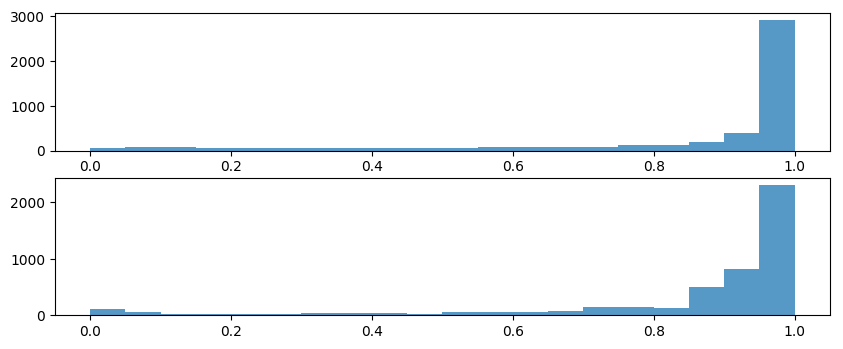

CPU times: user 3.39 s, sys: 297 ms, total: 3.69 s
Wall time: 3.35 s


In [8]:
%%time
# Use between 2 and 300 imports, balanced dataset
dataset5 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset5[dataset5.malware == 1])
goodware_count = len(dataset5[dataset5.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset5[dataset5.malware == 1].sample(n=limiting)
goodware = dataset5[dataset5.malware == 0].sample(n=limiting)

# Recreate the dataset, now balanced
dataset5 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset5[dataset5.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset5[dataset5.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset5, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()

Malware in dataset: 9434
Goodware in dataset: 4717
CC:	0.8970
DR:	0.9427
FP:	0.0936
FN:	0.1243

Malware stats:


count    4714.000000
mean        0.904000
std         0.188950
min         0.000003
25%         0.930720
50%         0.969920
75%         0.996365
max         1.000000
dtype: float64


Goodware stats:


count    2.362000e+03
mean     7.794856e-01
std      3.107167e-01
min      6.862127e-07
25%      6.769660e-01
50%      9.349017e-01
75%      9.985927e-01
max      1.000000e+00
dtype: float64

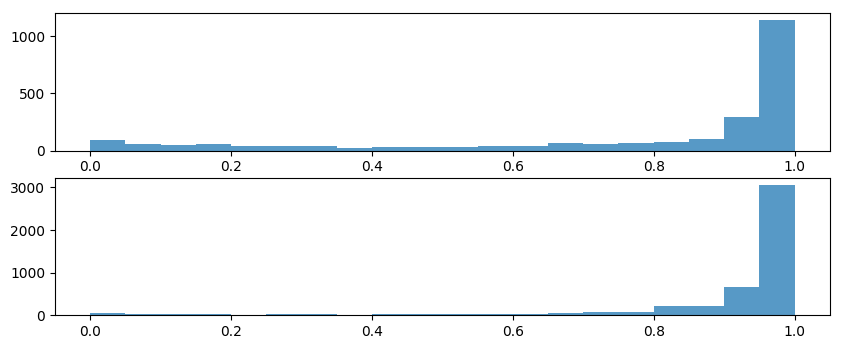

CPU times: user 2.79 s, sys: 313 ms, total: 3.11 s
Wall time: 2.75 s


In [9]:
%%time
# Use up to 300 imports, but with more malware than goodware
dataset6 = dataset[dataset.imports.map(lambda x: len(x.split(';')) <= 300 and len(x.split(';')) > 1)]
malware_count = len(dataset6[dataset6.malware == 1])
goodware_count = len(dataset6[dataset6.malware == 0])

limiting = min(malware_count, goodware_count)
malware = dataset6[dataset6.malware == 1].sample(n=limiting)
# Use 50% less goodware
goodware = dataset6[dataset6.malware == 0].sample(n=int(limiting * 0.5))

# Recreate the dataset, now balanced
dataset6 = pd.concat([malware, goodware])

print('Malware in dataset: {}'.format(len(dataset6[dataset6.malware == 1])))
print('Goodware in dataset: {}'.format(len(dataset6[dataset6.malware == 0])))

# Split into train and test (this also shuffles the data)
(train, test) = train_test_split(dataset6, test_size=test_size)

# Generate the count vectorizer
cv_token_pattern = u'[^;]+'
cv = CountVectorizer(token_pattern=cv_token_pattern)
train_X = cv.fit_transform(train.imports)
train_Y = train.malware
test_X = cv.transform(test.imports)
test_Y = test.malware

# Logistic Regression training
lr = LogisticRegression().fit(train_X, train_Y)

score = confusion_matrix(test_Y, lr.predict(test_X))
fp_rate, fn_rate, cc_rate, det_rate = jcfg_helpers.calc_ratios(score)
print('CC:\t{:.4f}'.format(cc_rate))
print('DR:\t{:.4f}'.format(det_rate))
print('FP:\t{:.4f}'.format(fp_rate))
print('FN:\t{:.4f}'.format(fn_rate))

malware_only = lr.predict_proba(test_X[np.where(test_Y == 1)])
goodware_only = lr.predict_proba(test_X[np.where(test_Y == 0)])
print('\nMalware stats:')
display(pd.Series(malware_only[:,1]).describe())
print('\nGoodware stats:')
display(pd.Series(goodware_only[:,0]).describe())

plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(211)
plt.hist(goodware_only[:,0], bins=20, alpha=0.75)
plt.subplot(212)
plt.hist(malware_only[:,1], bins=20, alpha=0.75)
plt.show()